In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit import transpile
from qiskit.circuit import ParameterVector, ClassicalRegister
from qiskit_aer import QasmSimulator
from PTC_utils import PTC_pairs, qaoa_PTC, decode_parity
from SWAP_utils import SWAP_pairs, qaoa_SWAP, qubit_order
from utils import total_cnots_depth, cost_maxcut, WMaxCut, qaoa, objective_MaxCut, random_samples, mitigate
from copy import copy
from simulated_annealing import simulated_annealing_func
import networkx as nx
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import os
service = QiskitRuntimeService()


/var/folders/76/d4kyjysx1xgdrrs6zzs63s180000gn/T/ipykernel_30576/2456209189.py:15: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


In [7]:
backends = {}
# backends["ibm_brisbane"] = service.backend("ibm_brisbane")
backends["qasm_simulator"] = QasmSimulator()

In [20]:
def method_SA(G, method, callback, max_iter_sa = 5, initial_temp=0.01, cooling_rate=0.999, stop_temp=1e-8, max_iter=10000, verbose=False):
    nq = G.number_of_nodes()
    if method == "PTC":
        list_2q = PTC_pairs(nq)
    elif method == "SWAP":
        list_2q = SWAP_pairs(nq)
    else:
        raise TypeError("Method not in list of methods")
    best_cost = 0
    for _ in range(10):
        best_map = dict(zip(range(nq),range(nq)))
        for i in range(max_iter_sa):
            best_map, current_cost, _ = simulated_annealing_func(G, best_map, list_2q, callback, initial_temp=initial_temp, cooling_rate=cooling_rate, stop_temp=stop_temp, max_iter=max_iter, verbose=verbose)
            if current_cost < best_cost:
                best_cost = current_cost
                global_best = copy(best_map)
            else:
                break
    mapping = {v: k for k, v in global_best.items()}
    G_shuffled = nx.relabel_nodes(G.copy(), mapping)
    _ , depth = total_cnots_depth(G_shuffled, list_2q)
    list_used = copy(list_2q[:nq+depth])
    return mapping, list_used




# Create the circuits

In [37]:
results = {}
seed = 123
results["seed"] = seed
method = ["SWAP","PTC","Qiskit-T"][2]
backend_name = "qasm_simulator"
# backend_name = "ibm_brisbane"
nq = 10

problem_name = "3MC"
G = nx.random_regular_graph(3, nq, seed=results["seed"])
for i, j in G.edges():
    G[i][j]["weight"] = 1
mdl = WMaxCut(G)
mdl.solve()
sol = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())

results["sol"] = sol
backend = backends[backend_name]

deltas = [0.5]

results["Deltas"]  = deltas
if method in ["SWAP", "PTC"]:
    callback = {"cost": [], "depth": [], "iterations": [], "T": [], "cost_cache": {}}
    mapping, list_used = method_SA(G, method, callback, initial_temp=0.01, cooling_rate=0.999, max_iter_sa=10, verbose=False)
    G_shuffled = nx.relabel_nodes(G.copy(), mapping)
    results["G_shuffled"] = G_shuffled
    results["mapping"] = mapping
    results["list_used"] = list_used


ps = [3,4,5,6]
results["ps"] = ps
results["optimal"] = sol
results["G"] = G
results["circuits"] = {}
results["depth"] = {}
circuits_transpiled = {}
for p in ps:
    betas = ParameterVector("betas", p)
    gammas = ParameterVector("gammas", p)
    if method == "PTC":
        qc = qaoa_PTC(gammas, betas, G_shuffled, list_used)
    elif method == "SWAP":
        qc = qaoa_SWAP(gammas, betas, G_shuffled, list_used)
    elif method == "Qiskit-T":
        qc = qaoa(gammas, betas, G)
    qc.add_register(ClassicalRegister(nq))
    qc.measure(reversed(range(nq)), range(nq))
    circ_device = transpile(qc, backend, optimization_level=1)
    circuits_transpiled[p] = circ_device
    results["circuits"][p] = circ_device.count_ops()
    results["depth"][p] = circ_device.depth()
    print(circ_device.count_ops(), circ_device.depth())

print("Depth reduction", nq - len(list_used))


circuits = []
for delta in deltas:
    print(f"Delta: -------  {round(delta,2)} ----------- ")
    for p in ps:
        
        betas = list(np.arange(1, p+1)[::-1] * delta / p)
        gammas = list(np.arange(1, p+1) * delta / p)
        backend_circ = circuits_transpiled[p].assign_parameters(np.concatenate((betas, gammas)))
        circuits.append(backend_circ)

OrderedDict([('rzz', 45), ('rx', 30), ('h', 10), ('measure', 10)]) 21
OrderedDict([('rzz', 60), ('rx', 40), ('h', 10), ('measure', 10)]) 27
OrderedDict([('rzz', 75), ('rx', 50), ('h', 10), ('measure', 10)]) 33
OrderedDict([('rzz', 90), ('rx', 60), ('h', 10), ('measure', 10)]) 39
Depth reduction 3
Delta: -------  0.5 ----------- 


# Run experiments

In [38]:
shots = 1000
results["shots"] = shots
version = ""
if backend_name != "qasm_simulator":
    sampler = Sampler(mode=backends[backend_name])
    submit_job = sampler.run(circuits, shots=shots)
    results["id"] = submit_job.job_id() # ID to retrieve the job once is done
else:
    dict_results = backends[backend_name].run(circuits, shots=shots).result().get_counts()
    if method == "PTC":
        samples = {p:{decode_parity(k, p, results["list_used"]):c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])}
        samples = {p:{"".join(k[results["mapping"][i]] for i in range(nq)):v for k, v in samples[p].items()} for p in results["ps"]}  
    elif method == "SWAP":
        samples = {p:{"".join(k[i] for i in (range(nq) if p%2==0 else np.argsort(qubit_order(nq, len(results["list_used"])-1)))):c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])}    
        samples = {p:{"".join(k[results["mapping"][i]] for i in range(nq)):v for k, v in samples[p].items()} for p in results["ps"]} 
    elif method == "Qiskit-T":
        samples = {p:{k:c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])} 
    results["samples"] = {results["Deltas"][0]: samples}

os.makedirs(f"./Data/{backend_name}/", exist_ok=True)
np.save(f"./Data/{backend_name}/{nq}_{problem_name}_{method}{seed}{version}.npy", results)

# Retrieved data real QPU

In [41]:
backend_name = "qasm_simulator"
method = ["SWAP","PTC","Qiskit-T"][2]
seed = 123
nq = 10
version = ""
problem_name = "3MC"
results = np.load(f"./Data/{backend_name}/{nq}_{problem_name}_{method}{seed}{version}.npy", allow_pickle=True).item()

if backend_name != "qasm_simulator":
    jobs = service.job(job_id=results["id"]).result()
    dict_results = [getattr(jobs[i].data, [i for i in dir(jobs[i].data) if i[0] == "c"][0]).get_counts() for i in range(len(jobs))]
    if method == "PTC":
        samples = {p:{decode_parity(k, p, results["list_used"]):c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])}
        samples = {p:{"".join(k[results["mapping"][i]] for i in range(nq)):v for k, v in samples[p].items()} for p in results["ps"]}  
    elif method == "SWAP":
        samples = {p:{"".join(k[i] for i in (range(nq) if p%2==0 else np.argsort(qubit_order(nq, len(results["list_used"])-1)))):c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])}    
        samples = {p:{"".join(k[results["mapping"][i]] for i in range(nq)):v for k, v in samples[p].items()} for p in results["ps"]}
    elif method == "Qiskit-T":
        samples = {p:{k:c for k, c in dict_results[ii].items()} for ii, p in enumerate(results["ps"])} 
    results["samples"] = {results["Deltas"][0]: samples}

# Postprocessing the samples using the objective function

In [42]:
nq = results["G"].number_of_nodes()
sections = 1

postprocessing = {}
postprocessing_mitig = {}
for delta in results["Deltas"]:
    print(f"----------- delta = {delta} -------------")
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["ps"]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}
        for sec in range(sections):
            samples_sec = defaultdict(int)
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec*nq:(sec+1)*nq]] += v
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["optimal"])
            new_samples = mitigate(samples_sec, results["G"], random=False)
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["optimal"])
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig
rand_samples = random_samples(10000, nq)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["optimal"])
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["optimal"])

np.save(f"./Data/{backend_name}/{nq}_{problem_name}_{method}{seed}{version}.npy", results)

----------- delta = 0.5 -------------
----------- p = 3 -------------
----------- p = 4 -------------
----------- p = 5 -------------
----------- p = 6 -------------


SWAP
[np.float64(0.88), np.float64(0.897), np.float64(0.917), np.float64(0.924)] 0.5767461538461538
[np.float64(0.193), np.float64(0.237), np.float64(0.341), np.float64(0.355)] 0.5767461538461538
0.8197117569016593
OrderedDict([('cx', 117), ('rx', 30), ('rz', 24), ('rzz', 21), ('h', 10), ('measure', 10)]) 44
PTC
[np.float64(0.875), np.float64(0.892), np.float64(0.91), np.float64(0.924)] 0.5762
[np.float64(0.173), np.float64(0.223), np.float64(0.296), np.float64(0.356)] 0.5762
0.8217591752277924
OrderedDict([('cx', 210), ('rz', 45), ('rx', 30), ('h', 10), ('measure', 10)]) 70
Qiskit-T
[np.float64(0.88), np.float64(0.893), np.float64(0.916), np.float64(0.922)] 0.5775846153846154
[np.float64(0.199), np.float64(0.238), np.float64(0.31), np.float64(0.356)] 0.5775846153846154
0.8164402520304476
OrderedDict([('rzz', 45), ('rx', 30), ('h', 10), ('measure', 10)]) 21


Text(0.5, 0, 'p')

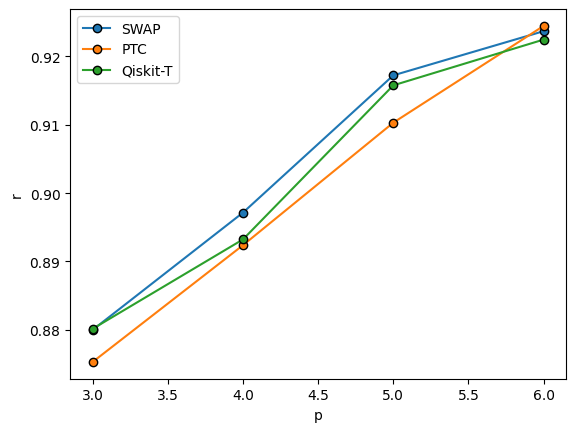

In [45]:
# backend_name = "ibm_brisbane"
import matplotlib.pyplot as plt
backend_name = "qasm_simulator"
problem_name = "3MC"
version = ""
methods = ["SWAP","PTC","Qiskit-T"]
seed = 123
nq = 10
fig, ax = plt.subplots()
for method in methods:
    results = np.load(f"./Data/{backend_name}/{nq}_{problem_name}_{method}{seed}{version}.npy", allow_pickle=True).item()
    print(method)

    ax.plot(results["ps"], [results["postprocessing"][0.5][p][0]["r"] for p in results["ps"]], label=method, marker="o", markeredgecolor="black")
    
    print([round(results["postprocessing"][0.5][p][0]["r"],3) for p in results["ps"]], results["random"]["r"])
    print([round(results["postprocessing"][0.5][p][0]["probability"],3) for p in results["ps"]], results["random"]["r"])
    print((max([results["postprocessing"][0.5][p][0]["r"] for p in results["ps"]]) - results["random"]["r"])/(1-results["random"]["r"]))
    print(results["circuits"][3], results["depth"][3])
ax.legend()
ax.set_ylabel("r")
ax.set_xlabel("p")